In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA

from multiprocessing import Pool
from threadpoolctl import threadpool_limits

import warnings
warnings.filterwarnings("ignore")

import emcee
import corner

import inspect

# SPCA libraries
from SPCA import helpers, astro_models, make_plots, make_plots_custom, detec_models, bliss, freeze
from SPCA import Decorrelation_helper as dh

# Enter in parameters that will define how the rest of the code will run

In [2]:
planet = 'WASP-43b'
channel = 'ch2'
mode = 'Poly2_v1'
rootpath = '/home/taylor/Documents/Research/spitzer/MEGA/'

# parameters you do not wish to fit
dparams_input = []

# parameters you want to place a gaussian prior on
gparams = ['t0', 'per', 'a', 'inc']

# parameters you want to place a uniform prior on
uparams = ['rp', 'fp', 'q1', 'q2', 'inc', 'ecosw', 'esinw', 'sigF', 'gpLx', 'gpLy']
uparams_limits = [[0,1], [0,1], [0,1], [0,1], [70,90], [-1,1], [-1,1], [0,1], [0,-3],[0,-3]]
uparams.extend(['p'+str(i)+'_1' for i in range(1,26)]) # First order PLD terms
uparams.extend(['p'+str(i)+'_2' for i in range(1,26)]) # Second order PLD terms
uparams_limits.extend([[-3,3] for i in range(1,26)])
uparams_limits.extend([[-500,500] for i in range(1,26)])

oldPhotometry = False                    # Whether photometry was computed before May 1, 2020 when flux conversion was patched
ncpu = 4                                 # The number of cpu threads to be used when running MCMC
runMCMC = True                           # whether to run MCMC or just load-in past results
nIterScipy = 10                          # Number of iterative scipy runs used to locate best-fit before starting MCMCs
nBurnInSteps2 = 7.5e5                    # number of steps to use for the second mcmc burn-in
nProductionSteps = 1.5e5                 # number of steps to use with mcmc production run
usebestfit = True                        # used best-fit instead of median of chain
blissNBin = 8                            # number of knots to allow in each direction
secondOrderOffset = False                # should you use the second order sinusoid terms when calculating offset
bestfitNbin = 50                         # the number of binned values to overplot on the bestfit 4-panel figure (use None if you don't want these overplotted)
nFrames  = 64                            # number of frames per binned data point
initializeWithOld = False                # initial with previous mcmc results using the same method
pldIgnoreFrames = True                   # Whether or not to use the PLD photometry that ignored bad frames
pldAddStack = False                      # Whether or not to use the PLD photometry that used background correction stacks
debug = False                            # True if user wants details about the lambda functions created

#non-unity if you have dilution by a nearby companion
compFactor = 1.

# non-zero if you want to remove some initial data points
cut_tmp = 0

# Everything below can be run without interfering with it

In [3]:
if rootpath[-1]!='/':
    rootpath += '/'

## Load data for fitting

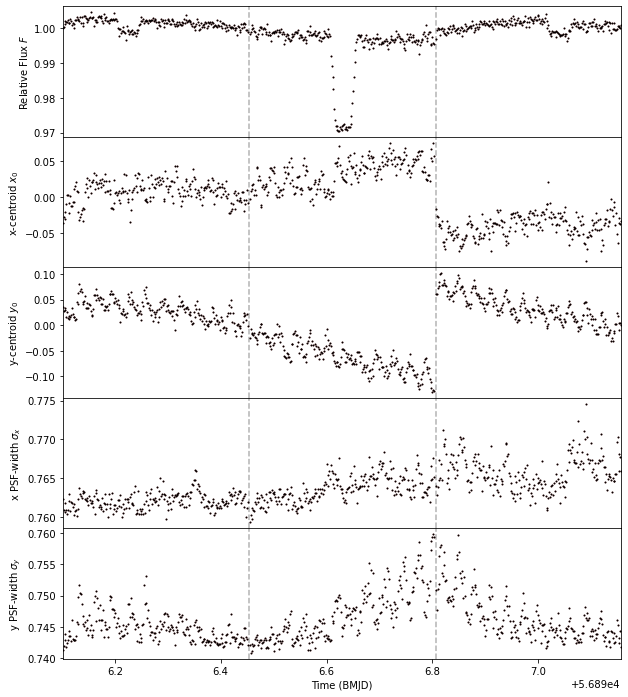

In [4]:
# Figure out where data is located
if 'pldaper' in mode.lower():
    # Get separately aperture data for when running PLDAper, and decide if ignoreFrame from aperture photometry
    foldername_aper = dh.findPhotometry(rootpath, planet, channel, 'Poly2_v1')[0]
    if len(ignoreFrames)==0:
        pldIgnoreFrames = False
    else:
        pldIgnoreFrames = True
    foldername_psf = ''
else:
    foldername_aper = ''

if 'psfx' in mode.lower():
    foldername_psf = dh.findPhotometry(rootpath, planet, channel, 'PSFX')[0]
else:
    foldername_psf = ''

(foldername, filename, filename_full, savepath,
path_params, AOR_snip, aors, breaks, ignoreFrames) = dh.findPhotometry(rootpath, planet, channel,
                                                                       mode, pldIgnoreFrames, pldAddStack)

with open(rootpath+planet+'/analysis/'+channel+'/cutFirstAOR.txt', 'r') as file:
    cutFirstAOR = file.readline().strip()=='True'

# For datasets where the first AOR is peak-up data
if cutFirstAOR:
    rawfiles = np.sort(os.listdir(rootpath+planet+'/data/'+channel+'/'+aors[0]+'/'+channel+'/bcd/'))
    rawfiles  = [rawfile for rawfile in rawfiles if '_bcd.fits' in rawfile]
    cut = cut_tmp+len(rawfiles)
else:
    cut = cut_tmp

# loading full data set for BIC calculation afterwards
if 'pld' in mode.lower():
    # get data from unbinned photometry for chi2 on unbinned data calculation later
    Pnorm_full, flux_full, time_full = helpers.get_full_data(foldername, filename_full, mode,
                                                             foldername_aper=foldername_aper,
                                                             cut=cut, nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    Pnorm_0, flux0, time0 = helpers.get_data(foldername, filename, mode,
                                             foldername_aper=foldername_aper)
    Pnorm, flux, time = helpers.get_data(foldername, filename, mode,
                                         foldername_aper=foldername_aper, cut=cut)
    
    pca = PCA(n_components=int(Pnorm_full.shape[0]-1))
    pca.fit(Pnorm_full.T)
    Pnorm_full = pca.transform(Pnorm_full.T).T
    Pnorm_full = np.append(np.ones_like(Pnorm_full[:1]), Pnorm_full, axis=0)
    
    pca = PCA(n_components=int(Pnorm.shape[0]-1))
    pca.fit(Pnorm.T)
    Pnorm = pca.transform(Pnorm.T).T
    Pnorm = np.append(np.ones_like(Pnorm[:1]), Pnorm, axis=0)
    
    if not oldPhotometry:
        if 'pldaper' in mode.lower():
            path_temp = foldername_aper+filename
        else:
            path_temp = foldername+filename
        sigF_photon_ppm = dh.get_photon_limit(path_temp, mode, nFrames, ignoreFrames)
    
    # FIX: Add an initial PLD plot
else:
    # get data from photometry
    (flux_full, time_full, xdata_full, ydata_full,
     psfxw_full, psfyw_full) = helpers.get_full_data(foldername, filename_full, mode,
                                                     foldername_psf=foldername_psf,
                                                     cut=cut, nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    (flux0, time0, xdata0, ydata0, psfxw0, psfyw0) = helpers.get_data(foldername, filename, mode,
                                                                      foldername_psf=foldername_psf)
    (flux, time, xdata, ydata, psfxw, psfyw) = helpers.get_data(foldername, filename, mode,
                                                                foldername_psf=foldername_psf, cut=cut)
    
    if not oldPhotometry:
        sigF_photon_ppm = dh.get_photon_limit(foldername+filename, mode, nFrames, ignoreFrames)
    
    ## FIX: peritime doesn't get made
    if True:#'ecosw' in dparams_input and 'esinw' in dparams_input:
        # make photometry plots
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                                   time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath,
                                   showPlot=True)
    else:
        # plot raw data
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                                   time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath,
                                   peritime, showPlot=True)

# Calculate the photon noise limit
if oldPhotometry:
    # Fix the old, unhelpful units to electrons to compute photon noise limit
    sigF_photon_ppm = dh.get_photon_limit_oldData(rootpath, foldername+filename, foldername_aper+filename_aper,
                                                  planet, channel, mode, aors, nFrames, ignoreFrames)

## Load archival/custom data and prepare some variables

In [5]:
## Download the most recent exoplanet archive data, and select the best constrained value for each parameter
dh.downloadExoplanetArchive()
if planet!='WASP-18b':
    p0_obj = dh.loadArchivalData(rootpath, planet, channel)

## If you would rather load your own data (e.g. your planet isn't in the exoplanet archive),
## you can use the function below. The error parameters are optional inputs, but are required if you want
## to put a prior on a parameter.
if planet=='WASP-18b':
    # The combination of parameters loaded for WASP-18b are not consistent with each other
    p0_obj = dh.loadCustomData(rootpath, planet, channel, 0.09716, 3.562, 0.9414526, 2458375.169883,
                               84.88, 0.0091, 269, 6431, 4.47, 0.11,
                               0.00014, 0.022, 0.000026, 0.0000016, 0.33, 0.00200, 3, 48)
# p0_obj = loadCustomData(rootpath, planet, channel, rp, a, per, t0, inc, e, argp, Tstar, logg, feh,
#                         rp_err, a_err, t0_err, per_err, inc_err, e_err, argp_err, Tstar_err)

# if you want to use the best fit params from a previous MCMC run            
if initializeWithOld:
    p0_obj = dh.reload_old_fit(path_params, p0_obj)
    
# makes list of parameters that won't be fitted 
dparams = helpers.expand_dparams(dparams_input, mode)

## Initialize the guessed parameters and prepare priors

In [6]:
p0, p0_labels, p0_fancyLabels = helpers.get_p0(dparams, p0_obj)

# Put gparams and uparams in the right order and remove any that aren't being fitted
gparams = np.array([parm for parm in p0_labels if parm in gparams])
uparams_unsorted = np.copy(uparams)
uparams = np.array([parm for parm in p0_labels if parm in uparams])
uparams_limits = np.array([uparams_limits[np.where(uparams_unsorted==uparams[i])[0][0]]
                           for i in range(len(uparams))])

gpriorInds = np.array([np.where(p0_labels==gpar)[0][0] for gpar in gparams])
upriorInds = np.array([np.where(p0_labels==upar)[0][0] for upar in uparams if upar in p0_labels])
if 'gp' in mode.lower():
    gammaInd = np.where(p0_labels=='gpAmp')[0][0]
else:
    gammaInd = None

# set up Gaussian priors
priors, errs = dh.setup_gpriors(gparams, p0_obj)

## Setup detector, astrophysical, and full-signal functions

In [7]:
# Get the astrophysical function
astro_func, astro_labels = freeze.make_lambdafunc(astro_models.ideal_lightcurve, p0_labels,
                                                  dparams, p0_obj, debug=debug)
astro_inputs = time
astro_inputs_full = time_full

# Compute an initial guess for the astro model
astro_guess = astro_func(astro_inputs, **dict([[label, p0[i]] for i, label in enumerate(p0_labels)
                                               if label in astro_labels]))

# Get the function that checks whether the lightcurve is positive
positivity_func = freeze.make_lambdafunc(astro_models.check_phase, p0_labels,
                                         np.append(dparams, 'checkPhasePhis'), p0_obj, debug=debug)
positivity_labels = np.array([label for label in ['A', 'B', 'C', 'D'] if label not in dparams])

# Get all of the detector functions used and freeze any requested parameters
detec_funcs = []
# Get the names of the fitted parameters for each function
detec_labels = []
# Get the inputs needed for each detector function
detec_inputs = []
detec_inputs_full = []
if 'poly' in mode.lower():
    func = detec_models.detec_model_poly
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append([xdata, ydata, mode])
    detec_inputs_full.append([xdata_full, ydata_full, mode])
if 'pld' in mode.lower():
    func = detec_models.detec_model_PLD
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append([Pnorm, mode])
    detec_inputs_full.append([Pnorm_full, mode])
if 'bliss' in mode.lower():
    func = detec_models.detec_model_bliss
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append(bliss.precompute(flux, xdata, ydata, mode,
                                        blissNBin, astro_guess, savepath, plot=True))
    detec_inputs_full.append(bliss.precompute(flux_full, xdata_full, ydata_full,
                                             blissNBin))
if 'gp' in mode.lower():
    func = detec_models.detec_model_GP
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append([flux, xdata, ydata, True])
    detec_inputs_full.append([flux_full, xdata_full, ydata_full, True])
if 'hside' in mode.lower():
    for i, brk in enumerate(breaks):
        # Set the break points for the heaviside function
        p0_obj[f's{i}break'] = brk
        dparams = np.append(dparams, [f's{i}break'])
    func = detec_models.hside
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append(time)
    detec_inputs_full.append(time_full)
if 'tslope' in mode.lower():
    func = detec_models.tslope
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append(time)
    detec_inputs_full.append(time_full)
if 'psfw' in mode.lower():
    func = detec_models.detec_model_PSFW
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append(psfxw, psfyw)
    detec_inputs_full.append(psfxw_full, psfyw_full)
    
if len(detec_funcs)==0:
    raise NotImplementedError(f'mode=\'{mode}\' is not implemented.')
    
# Get the full-signal function that models the astrophysical and detector signals
signal_func = detec_models.signal
signal_inputs = [p0_labels, astro_func, astro_labels, astro_inputs, detec_funcs, detec_labels, detec_inputs]
signal_inputs_full = [p0_labels, astro_func, astro_labels, astro_inputs_full,
                      detec_funcs, detec_labels, detec_inputs_full]

lnprob_inputs = [flux, mode, p0_labels, signal_func, signal_inputs,
                 gpriorInds, priors, errs, upriorInds, uparams_limits, gammaInd,
                 positivity_func, positivity_labels]

NameError: name 'p0_labels' is not defined

## Run initial optimization on detector parameters

### Run several gradient descents, short MCMCs, and then gradient descents to allow full burn-in

#### Feel free to use your own maximum likelihood method - here we just offer a simple method that should often work. The objective of this step is just to start the final MCMC in a reasonable region of parameter space

In [ ]:
if runMCMC and not initializeWithOld:
    
    p0 = dh.burnIn(p0, p0_labels, mode, astro_func, astro_labels, astro_inputs, signal_func, signal_inputs,
                   lnprob_inputs, gparams, gpriorInds, priors, errs, time, flux, breaks, bestfitNbin, 
                   ncpu, savepath, showPlot=True, nIterScipy=nIterScipy)

## Run the MCMC

In [ ]:
ndim, nwalkers = len(p0), 150

if runMCMC:
    # get scattered starting points in parameter space
    # MUST have the initial spread such that every walker passes the lnprior functions
    p0_rel_errs = 1e-4*np.ones_like(p0)
    gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
    p0_rel_errs[gpriorInds] = np.array(errs)/np.array(priors)
    pos0 = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim))
                     for i in range(nwalkers)])

    # Make sure that all starting positions pass the lnpriors, fix them if they don't
    priorlnls = np.array([np.isinf(helpers.lnprob(p_tmp, *lnprob_inputs)) for p_tmp in pos0])
    iters = 10
    while np.any(priorlnls) and iters>0:
        p0_rel_errs /= 1.5
        pos0[priorlnls] = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))
                                      +p0_rel_errs/10.*np.abs(np.random.randn(ndim))
                                    for i in range(np.sum(priorlnls))])
        priorlnls[priorlnls] = np.array([np.isinf(helpers.lnprob(p_tmp, *lnprob_inputs))
                                         for p_tmp in pos0[priorlnls]])
        iters -= 1
    if iters==0 and np.any(priorlnls):
        print('Warning: Some of the initial values still fail the lnprior!')
        print('The following MCMC will likely not work')

    # Run the MCMC
    print('Running MCMC')
    with threadpool_limits(limits=1, user_api='blas'):
        with Pool(ncpu) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, helpers.lnprob, args=lnprob_inputs,
                                            a = 2, pool=pool)
            pos2, prob, state = sampler.run_mcmc(pos0, np.rint((nBurnInSteps2+nProductionSteps)/nwalkers),
                                                 progress=True)
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
    
    # Show the evolution of MCMC walkers
    burnInChain = sampler.chain[:,:int(np.rint((nBurnInSteps2)/nwalkers)),:]
    fname = savepath+'MCMC_burninWalkers_'+mode+'.pdf'
    make_plots.walk_style(burnInChain, p0_fancyLabels, 10, fname, showPlot=True)
    
    # Get only the production steps
    lnprobchain = sampler.get_log_prob(discard=int(np.rint((nBurnInSteps2)/nwalkers))).swapaxes(0,1)
    chain = sampler.get_chain(discard=int(np.rint((nBurnInSteps2)/nwalkers))).swapaxes(0,1)

    #Saving MCMC Results
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathlnlchain = savepath + 'samplerlnlchain_'+mode+'.npy'
    pathposit = savepath + 'samplerposi_'+mode+'.npy'
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    np.save(pathchain, chain)
    np.save(pathlnlchain, lnprobchain)
    np.save(pathposit, pos2)
    np.save(pathlnpro, prob)   
    
else:

    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathlnlchain = savepath + 'samplerlnlchain_'+mode+'.npy'
    chain = np.load(pathchain)
    lnprobchain = np.load(pathlnlchain)
    
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    if os.path.exists(pathlnpro):
        lnprobability = np.load(pathlnpro)

samples = chain.reshape((-1, ndim))

## Output results from MCMC

In [ ]:
p0_mcmc, MCMC_Results, residuals = dh.print_MCMC_results(flux, flux_full, chain, lnprobchain, mode, channel,
                                                         signal_func, signal_inputs, signal_inputs_full,
                                                         p0_labels, p0_obj, astro_func, astro_inputs,
                                                         astro_inputs_full, astro_labels, usebestfit, savepath,
                                                         sigF_photon_ppm, nFrames, secondOrderOffset,
                                                         compFactor)

In [ ]:
# Make a plot showing the evolution of the astro parameters
ind_a = len(astro_labels) # index where the astro params
labels = p0_fancyLabels[np.in1d(p0_labels, astro_labels)]
fname = savepath+'MCMC_astroWalkers_'+mode+'.pdf'
make_plots.walk_style(chain[:,:,:ind_a], labels, 10, fname, showPlot=True)

# Make a plot showing the evolution of the detector parameters
if 'bliss' not in mode.lower() or r'$\sigma_F$' in p0_fancyLabels:
    labels = p0_fancyLabels[np.logical_not(np.in1d(p0_labels, astro_labels))]
    fname = savepath+'MCMC_detecWalkers_'+mode+'.pdf'
    make_plots.walk_style(chain[:,:,ind_a:], labels, 10, fname, showPlot=True)

# Make a corner plot for the astro parameters
if runMCMC:
    labels = p0_fancyLabels[np.in1d(p0_labels, astro_labels)]
    fig = corner.corner(samples[:,:ind_a], labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                        plot_datapoints=True, title_kwargs={"fontsize": 12})
    plotname = savepath + 'MCMC_corner_'+mode+'.pdf'
    fig.savefig(plotname, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# Clear out the RAM
samples = None
sampler = None
chain = None
lnprobchain = None

## Plot the final model (best-fit parameters if usebestfit==True, otherwise median of MCMC chain)

In [ ]:
astroModel = astro_func(astro_inputs, **dict([[label, p0_mcmc[i]] for i, label in enumerate(p0_labels)
                                              if label in astro_labels]))
signalModel = signal_func(p0_mcmc, *signal_inputs)
detecModel = signalModel/astroModel

make_plots.plot_model(time, flux, astroModel, detecModel, breaks, savepath, 'Bestfit_'+mode+'.pdf',
                      nbin=bestfitNbin, showPlot=True, fontsize=24)

In [ ]:
#WARNING: these durations assume circular orbits!!!
intTime = (time[1]-time[0])
ingrDuration = helpers.getIngressDuration(p0_mcmc, p0_labels, p0_obj, intTime)
occDuration = helpers.getOccultationDuration(p0_mcmc, p0_labels, p0_obj, intTime)

minBins = 5

make_plots.plot_rednoise(residuals, minBins, ingrDuration, occDuration, intTime,
                         mode, savepath, savetxt=True, showPlot=True)

## Look for residual correlations after fit

In [ ]:
if 'pld' not in mode.lower():
    make_plots.look_for_residual_correlations(time, flux, xdata, ydata, psfxw, psfyw, residuals,
                                              p0_mcmc, p0_labels, p0_obj, mode, savepath, showPlot=True)